In [ ]:
import os
import numpy as np
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import pandas as pd

In [2]:
x = np.load('pose_landmarks_dataset.npy')
y = np.load('pose_landmarks_labels.npy')

In [3]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [4]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

In [6]:
from keras.applications import MobileNetV2
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, TimeDistributed, LSTM, Dropout
from keras.optimizers import Adam

In [8]:
# Assuming you already have x_train and x_val processed
num_classes = len(np.unique(y_train_encoded))

# Define the input shape based on your landmarks data
input_shape = (x_train.shape[1], x_train.shape[2])  # (timesteps, features)

In [9]:
# Load the pre-trained MobileNetV2 model without the top classification layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
from keras.layers import Input
inputs = Input(shape=input_shape)
x = LSTM(128, return_sequences=True)(inputs)
x = Dropout(0.4)(x)
x = LSTM(64)(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(num_classes, activation='softmax')(x)

In [11]:
# Create the model
from keras.models import Model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(x_train, y_train_encoded, 
                    validation_data=(x_val, y_val_encoded), 
                    epochs=600, batch_size=32)
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, label='Training Accuracy', color='blue')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='orange')

plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# Save the model
model.save('/kaggle/working/tf_pretrained_model.h5')

In [13]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score

model = load_model('/kaggle/working/tf_pretrained_model.h5')

predictions = model.predict(x_val)
predicted_classes = predictions.argmax(axis=1) 

accuracy = accuracy_score(y_val_encoded, predicted_classes)
print(f'TensorFlow Model Validation Accuracy: {accuracy:.4f}')

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
TensorFlow Model Validation Accuracy: 0.8724


In [15]:
# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Epoch 1/600
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - accuracy: 0.9111 - loss: 0.2443 - val_accuracy: 0.8399 - val_loss: 0.4853
Epoch 2/600
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.8932 - loss: 0.2676 - val_accuracy: 0.8707 - val_loss: 0.3732
Epoch 3/600
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.9138 - loss: 0.2271 - val_accuracy: 0.8574 - val_loss: 0.4520
Epoch 4/600
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.9193 - loss: 0.2140 - val_accuracy: 0.8557 - val_loss: 0.4467
Epoch 5/600
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.9018 - loss: 0.2598 - val_accuracy: 0.8782 - val_loss: 0.3897
Epoch 6/600
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.9069 - loss: 0.2472 - val_accuracy: 0.8532 - val_loss: 0.3844
Epoch 7/600
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9171 - loss: 0.2047 - val_accuracy: 0.8157 - val_loss: 0.6184
Epoch 8/600
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.8768 - loss: 0.3215 -

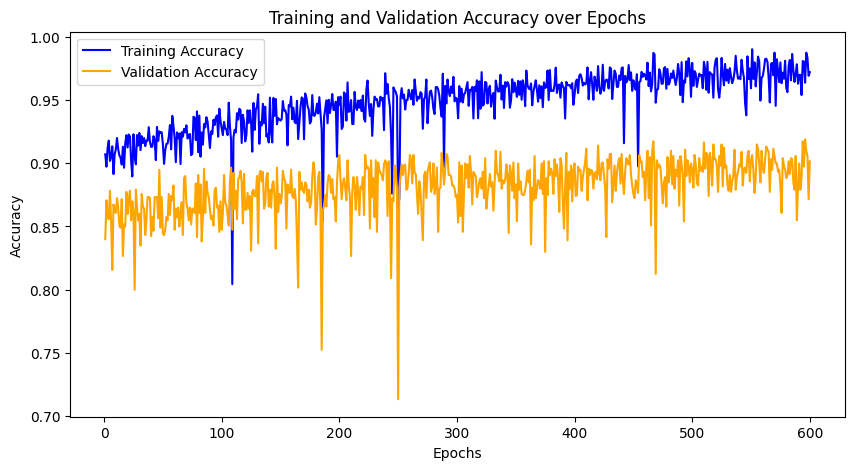

In [ ]:
# Train the model
history = model.fit(x_train, y_train_encoded, 
                    validation_data=(x_val, y_val_encoded), 
                    epochs=600, batch_size=32)
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, label='Training Accuracy', color='blue')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='orange')

plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# Save the model
model.save('/kaggle/working/tf_pretrained_model.h5')
loss, tf_keras_val_accuracy = model.evaluate(x_val, y_val_encoded, verbose=0)
print(f'TensorFlow/Keras Model Validation Accuracy: {tf_keras_val_accuracy:.4f}')

y_pred = model.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_val_encoded, y_pred_classes, target_names=label_encoder.classes_))